# Stereo Depth Estimation
## CUDA Vision Lab SS21
### Member 1 : Sanket Rajendra Shah ( 3314026 ) - s6sashah@uni-bonn.de
### Member 1 : Rahul Kumar ( <Mat No.> ) - <email > 

In [1]:
import os
os.chdir("../")

In [2]:
from dataloader.kitti import list_file_path
from dataloader import stereo_loader
from dataloader import transforms
from torch.utils.data import DataLoader
from models import stereo_depth 
import configparser
import torch
from tqdm import tqdm
import numpy as np
from torch import nn
from matplotlib import pyplot as plt

## Reading from Configuration Files

In [3]:
config = configparser.ConfigParser()
config.read("configs/kitti.config")
learning_rate = config.getfloat("Training", "learning_rate")
epochs = config.getint("Training", "epochs")
eval_freq = config.getint("Training", "eval_freq")
save_freq = config.getint("Training", "save_freq")
batch_size = config.getint("Training", "batch_size")
datapath_training = config.get("Data", "datapath_training")

## Loading Data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stereo_path_list_train = list_file_path.get_image_pair_names(datapath_training, mode="train")
stereo_path_list_val = list_file_path.get_image_pair_names(datapath_training, mode="eval")

stereo_dataset_train = stereo_loader.StereoPair(stereo_path_list_train,
                                                transforms=transforms.get_transforms(),mode="train")
stereo_dataset_val = stereo_loader.StereoPair(stereo_path_list_val,
                                              transforms=transforms.get_transforms(),mode="eval")

dataloader_train = DataLoader(stereo_dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_validation = DataLoader(stereo_dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

## Function for Evaluation, 3 Pixel Error and Plotting

In [5]:
def three_pixel_error(gt_disparity,predicted_disparity):
    abs_diff = torch.abs(gt_disparity - predicted_disparity)
    correct_disparity_pixels = torch.where((abs_diff < 3) | (abs_diff < 0.05 * gt_disparity))
    correct_disparity = torch.zeros_like(gt_disparity)
    correct_disparity[correct_disparity_pixels] = 1
    three_pixel_error = 1 - correct_disparity.mean()
    return three_pixel_error

In [14]:
@torch.no_grad()
def evaluate_and_display(model):

    criterion = torch.nn.SmoothL1Loss()
    three_pe_list = []
    loss_list=[]
    image_list=[]

    for batch in dataloader_validation:
        left_image = batch[0].to(device)
        right_image = batch[1].to(device)
        gt_disparity = batch[2].squeeze(1).to(device)
        l = batch[3]
        r = batch[4]
        non_zero_disp_indices = torch.where(gt_disparity > 0)
        zero_disp_indices = torch.where(gt_disparity == 0)
        predicted_disparity = model(left_image, right_image)
        predicted_disparity[zero_disp_indices]=0
        image_list.append([l,r,predicted_disparity])
        three_pe = three_pixel_error(gt_disparity[non_zero_disp_indices], predicted_disparity[non_zero_disp_indices])
        three_pe_list.append(three_pe.to("cpu"))
        loss = criterion(predicted_disparity[non_zero_disp_indices], gt_disparity[non_zero_disp_indices])
        loss_list.append(loss.item())
        
    t=torch.Tensor(three_pe_list)
    best_index = t.argsort()[0]
    worst_index = t.argsort()[-1]
    best_image = image_list[best_index]
    worst_image = image_list[worst_index]
    return three_pe_list, loss_list, best_image, worst_image

In [41]:
def plot_image(l,r,d, pe):
    fig = plt.figure(figsize=(6,6))
    cols = 1
    rows = 3
    fig.add_subplot(rows, cols, 1)
    plt.imshow(l.squeeze(0).permute(1,2,0))
    fig.add_subplot(rows, cols, 2)
    plt.imshow(r.squeeze(0).permute(1,2,0))
    fig.add_subplot(rows, cols, 3)
    plt.imshow(d.cpu().squeeze(0))
    plt.suptitle(pe)
    plt.show()

In [15]:
m=torch.load("../models/model_trilinear_no_aug.pth")
pe_mean,loss_mean,best, worst = evaluate_and_display(m["model"])

# Results 

### Worst Performing Image Pair

In [39]:
worst_3pe = sorted(pe_mean)[-1]

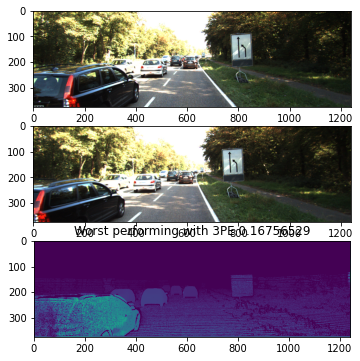

In [40]:
plot_image(*worst, "Worst performing with 3PE "+str(np.array(worst_3pe)))

### Best Performing Image Pair

In [25]:
best_3pe = sorted(pe_mean)[0]

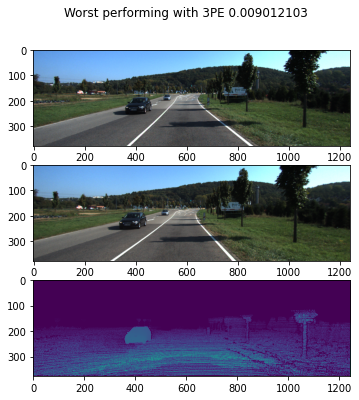

In [27]:
plot_image(*best, "Worst performing with 3PE "+str(np.array(best_3pe)))

### Training and Validatin Loss

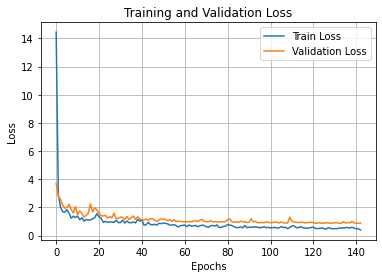

In [58]:
stats = m["stats"]
plt.plot(stats["train_loss"],label="Train Loss")
plt.plot(stats["valid_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

### 3 Pixel Error Loss

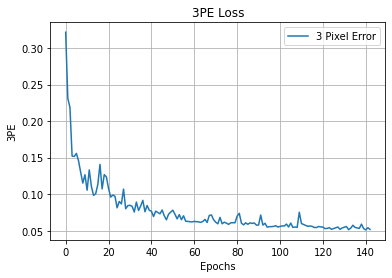

In [61]:
plt.plot(stats["accuracy"],label='3 Pixel Error')
plt.xlabel("Epochs")
plt.ylabel("3PE")
plt.title("3PE Loss")
plt.legend()
plt.grid()
plt.show()